In [1]:
%load_ext tikzmagic

---
slug: "/blog/linearregression"
date: "2021-03-15"
title: "Linear Regression"
category: "1 Machine Learning"
order: 1
---

### Introduction

Linear regression is a parametric regression method that is used to estimate real-valued outputs given real-valued input vectors. 
In this post, mean squared error is used as a loss function and gradient descent (or batched gradient descent) is used to learn parameters.

The computation graph below shows how linear regression works. 
The dot product of each input, a vector $\vec{x}$ of size $D$, and weight vector $\vec{w}$ transposed is taken to produce the output $h(x)$. 
The loss is then calculated by calculating the mean squared error using $y$ and output $h(x)$.

The bias term $\beta$ is ignored for the purposes of this post, but can easily be appended to weight vector $\vec{w}$ after appending a $1$ to an input vector $\vec{x}$.

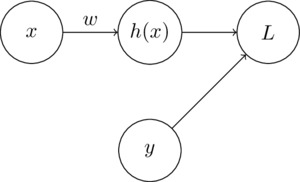

In [2]:
%%tikz -s 300,300 -sc 2
\node[draw, circle, minimum width=3em] (x) at (0, 1) {$x$};
\node[draw, circle, minimum width=3em] (hx) at (1, 1) {$h(x)$};
\node[draw, circle, minimum width=3em] (y) at (1, 0) {$y$};
\node[draw, circle, minimum width=3em] (l) at (2, 1) {$L$};
\draw[->] (x) edge node[midway, above] {$w$} (hx);
\draw[->] (hx) -- (l);
\draw[->] (y) -- (l);

### Learning

Given a data set $X$ of size $N$ with $D$ dimensions, parameters $w$ must be learned that minimize our loss function $L_{MSE}(y, \hat{y})$.
The weight vector is learned using gradient descent.
The derivation for term $\frac{\partial L}{\partial w}$ in the weight update is displayed in the derivations section of this post.

$$
\begin{aligned}
        h(x) &= w^T \cdot x & \text{[Prediction]}\\
        L_{\text{MSE}}(y, \hat{y}) &= \frac{1}{N}\sum^N_{i=1} (y-\hat{y})^2  &\text{[Mean squared error]}\\
        w_i &= w_i - \alpha \frac{\partial L}{\partial w_i} & \text{[Weight update]}\\
        &= w_i - \alpha \left[x_i(y - h(x))\right] &\\
        w_i &= w_i - \alpha \frac{1}{B}\sum^{B}_{j=1} x_{j,i} (y-h(x)) & \text{[Batch weight update]}\\
\end{aligned}
$$

### Code

Code for a linear regressor class is shown in the block below

In [3]:
from typing import List
from tqdm import trange
import torch


def MeanSquaredError(y: torch.Tensor, yhat: torch.Tensor) -> float:
    """ Calculate mean squared error rate

    Args:
        y: true labels
        yhat: predicted labels

    Returns:
        mean squared error        
    """

    return torch.sum((y - yhat)**2) / y.shape[0]


class LinearRegressor:


    def __init__(self) -> None:
        """ Instantiate linear regressor 
        """

        self.w = None
        self.calcError = MeanSquaredError


    def fit(self, x: torch.Tensor, y: torch.Tensor, alpha: float=0.00001, epochs: int=1000, batch: int=32) -> None:
        """ Fit logistic regression classifier to data set

        Args:
            x: input data
            y: input labels
            alpha: alpha parameter for weight update
            epochs: number of epochs to train
            batch: size of batches for training
        """

        self.w = torch.zeros((1, x.shape[1]))

        epochs = trange(epochs, desc='Error')
        for epoch in epochs:

            start, end = 0, batch
            for b in range((x.shape[0]//batch)+1):
                hx = self.predict(x[start:end])
                dw = self.calcGradient(x[start:end], y[start:end], hx)
                self.w = self.w - (alpha * dw)
                start += batch
                end += batch

            hx = self.predict(x)
            error = self.calcError(y, hx)
            epochs.set_description('MSE: %.4f' % error)


    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """ Predict output values 

        Args:
            x: input data

        Returns:
            regression output for each member of input
        """


        return torch.einsum('ij,kj->i', x, self.w)


    def calcGradient(self, x: torch.Tensor, y: torch.tensor, hx: torch.Tensor) -> torch.Tensor:
        """ Calculate weight gradient

        Args:
            x: input data
            y: input labels
            hx: predicted output

        Returns:
            tensor of gradient values the same size as weights
        """

        return torch.einsum('ij,i->j', -x, (y - hx)) / x.shape[0]

### Derivations

Derivative of loss function $L$ with respect to the regression output $h(x)$:

$$
\begin{aligned}
    \frac{\partial L}{\partial h(x)} &= \frac{\partial}{\partial h(x)} (y - h(x))^2 \\
    &= 2(y - h(x))
\end{aligned}
$$

Derivative of regression output $h(x)$ with respect to weight $w_i$:

$$
\begin{aligned}
    \frac{\partial h(x)}{\partial w_i} &= \frac{\partial}{\partial w_i} \sum^D_{j=1} w_j \times x_j\\
    &= x_i
\end{aligned}
$$

Derivative of loss function $L$ with respect to weight $w_i$:

$$
\begin{aligned}
    \frac{\partial L}{\partial w_i} &= \frac{\partial h(x)}{\partial w}\frac{\partial L}{\partial h(x)}\\
    &= 2x_i(y-h(x)) \\
    &\propto x_i(y-h(x))\\
\end{aligned}
$$

### Resources
- Russell, Stuart J., et al. Artificial Intelligence: A Modern Approach. 3rd ed, Prentice Hall, 2010.
- Burkov, Andriy. The Hundred Page Machine Learning Book. 2019.